## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot



# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# calibration image
img_orig = cv2.imread('camera_cal/calibration3.jpg')
img = img_orig.copy()
undist = img_orig.copy()
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Find the chessboard corners
gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY) 
ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

# If found, add object points, image points
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)

# calibrate camera
ret2,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)

#undistort
undist = cv2.undistort(img, mtx, dist, None, mtx)
 
#cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)

src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
offset = 100
img_size = (gray.shape[1], gray.shape[0])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist, M, img_size)



# Plot the Warped Chessboard

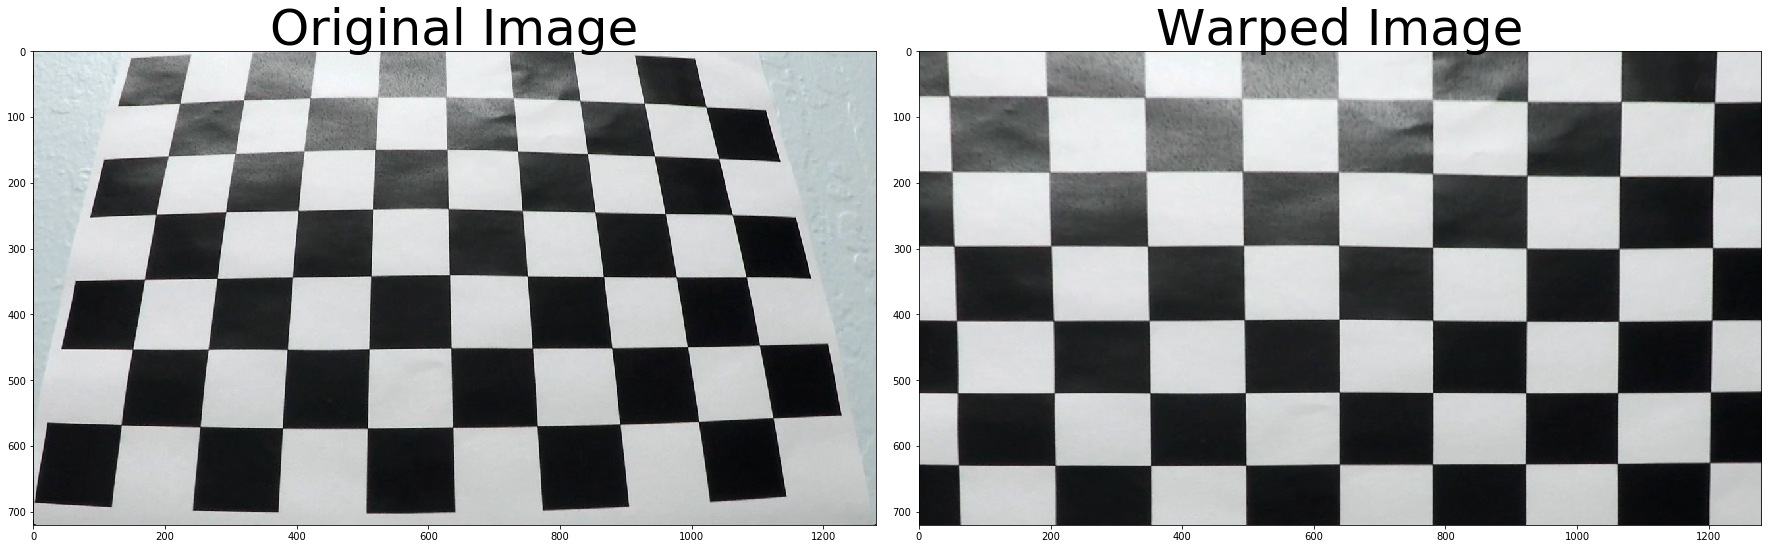

In [2]:
# Draw and display the corners

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_orig)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/'+'warped_check')

In [3]:
def unwarp(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    offset = 100
    img_size = (gray.shape[1], gray.shape[0])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

# Pipeline (Test Images)

## Unwarp and Undistort Test Images

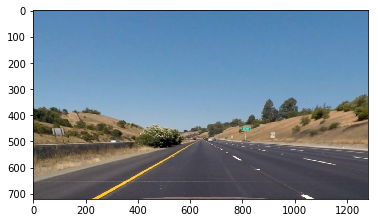

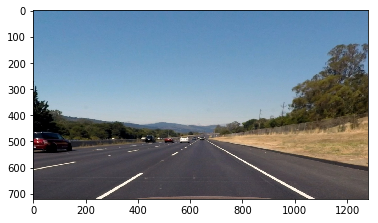

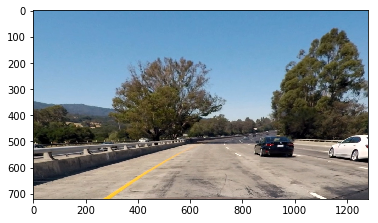

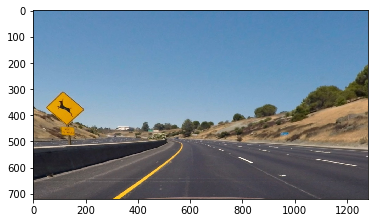

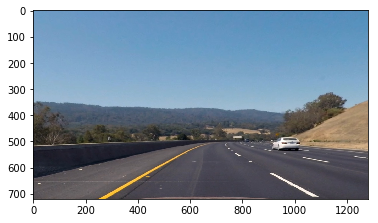

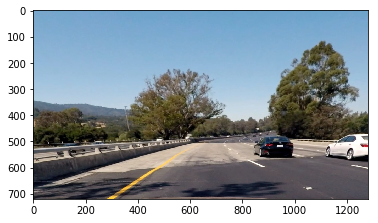

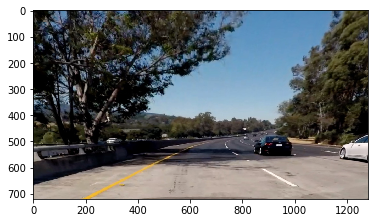

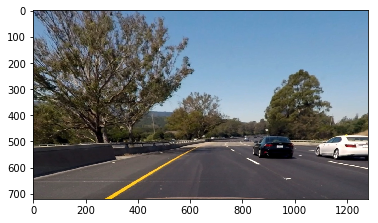

In [4]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')
n = 0
# Step through the list and search for chessboard corners
for fname in images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    plt.figure(fname)
    plt.imshow(unwarp(test_img,mtx,dist))
    plt.savefig('output_images/warped'+str(n)+'.jpg')
    n = n + 1

#  Use color transforms, gradients or other methods to create a thresholded binary image.

In [5]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


def explore(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(1, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return gradx,grady,mag_binary,dir_binary,combined 


def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # combine the color binary to black and white
    combined = np.dstack((np.max(color_binary, axis = 2), np.max(color_binary, axis = 2), np.max(color_binary, axis = 2)))
    return color_binary, combined
    

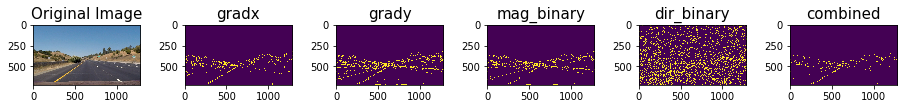

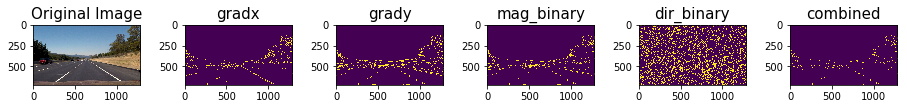

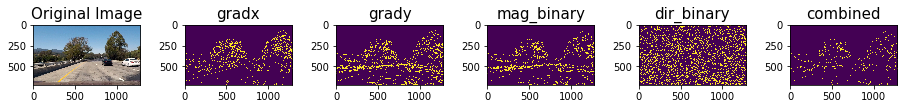

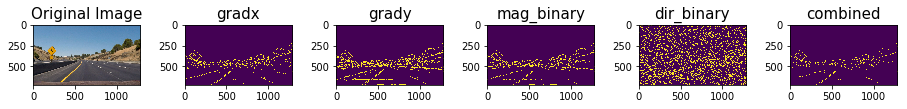

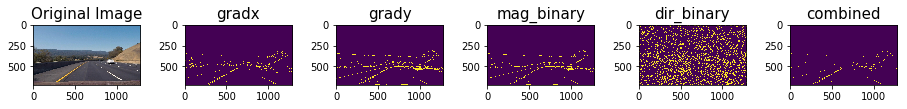

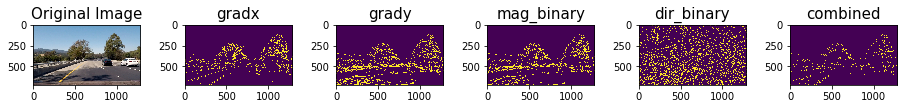

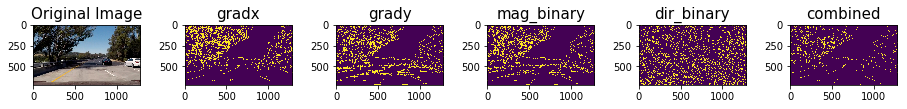

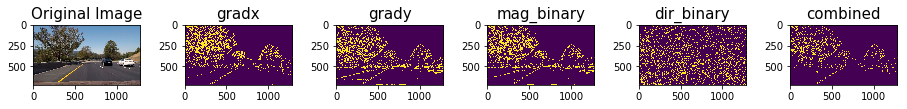

In [6]:

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
for fname in images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img_orig = test_img.copy()
    test_img = unwarp(test_img,mtx,dist)

    gradx,grady,mag_binary,dir_binary,combined = explore(test_img)
    plt.figure(fname)
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(test_img_orig)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(gradx)
    ax2.set_title('gradx', fontsize=15)
    ax3.imshow(grady)
    ax3.set_title('grady', fontsize=15)
    ax4.imshow(mag_binary)
    ax4.set_title('mag_binary', fontsize=15)
    ax5.imshow(dir_binary)
    ax5.set_title('dir_binary', fontsize=15)
    ax6.imshow(combined)
    ax6.set_title('combined', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


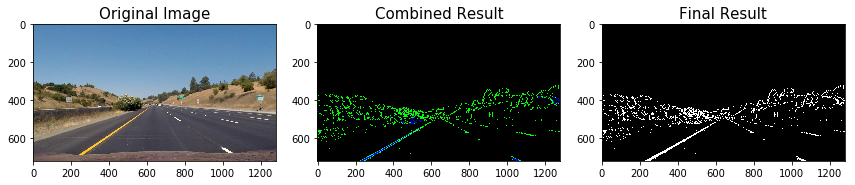

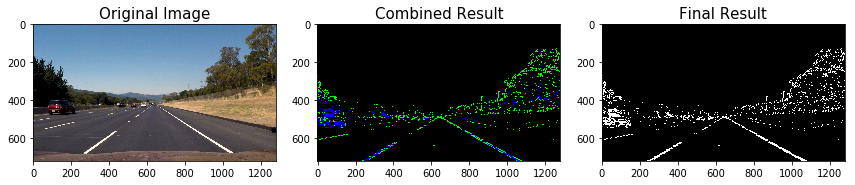

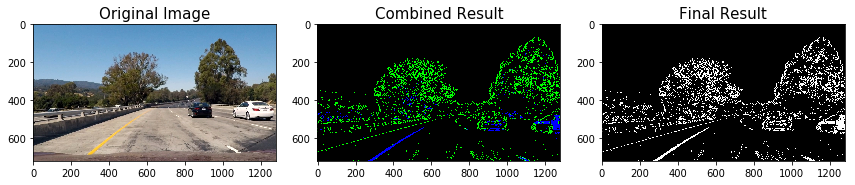

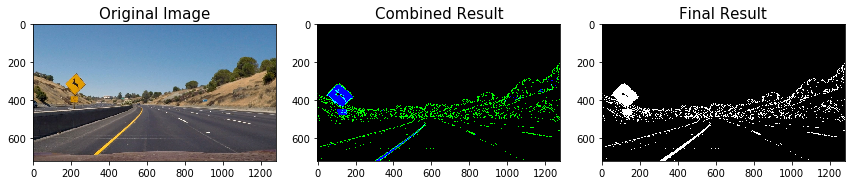

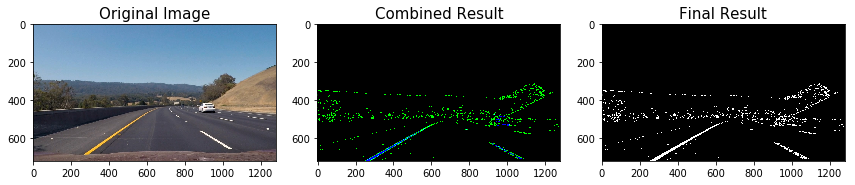

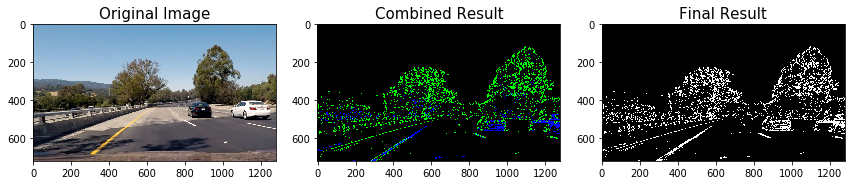

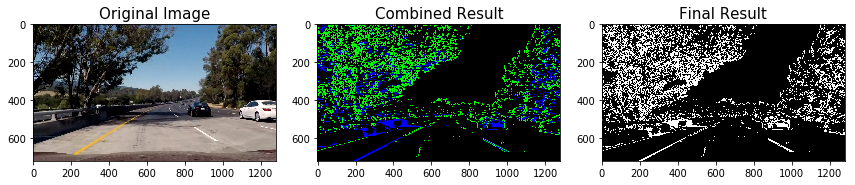

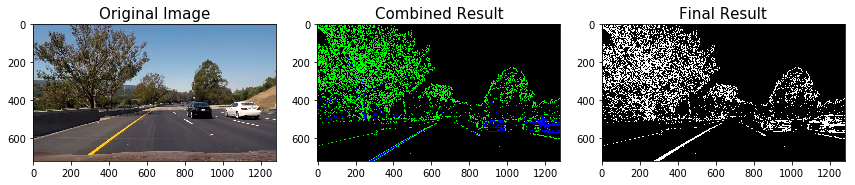

In [7]:

for fname in images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img_orig = test_img.copy()
    test_img = unwarp(test_img,mtx,dist)
    
    combined, final = pipeline(test_img)
    plt.figure(fname)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(test_img_orig)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(combined)
    ax2.set_title('Combined Result', fontsize=15)
    ax3.imshow(final)
    ax3.set_title('Final Result', fontsize=15)

## Perform a perspective transform and provide an example of a transformed image.  Identify lane-line pixels and fit their positions with a polynomial. 

## Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

In [8]:
# define unwarp function to top-down view of lane lines
def unwarp_lane(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    src = np.float32([(190,719),(591,448),(687,448),(1126,719)])
    offset = 100
    img_size = (gray.shape[1], gray.shape[0])
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
    #                         [img_size[0]-offset, img_size[1]-offset], 
    #                        [offset, img_size[1]-offset]])
    dst = np.float32([(200,700),(200,0),(1100,0),(1150,700)])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

def unwarp_lane2(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    offset = 60
    offset2 = 10
    src = np.float32([(190+offset,719),(591+offset,448),(687+offset2,448),(1126+offset2,719)])
    
    img_size = (gray.shape[1], gray.shape[0])
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
    #                         [img_size[0]-offset, img_size[1]-offset], 
    #                        [offset, img_size[1]-offset]])
    dst = np.float32([(200,700),(200,0),(1100,0),(1150,700)])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

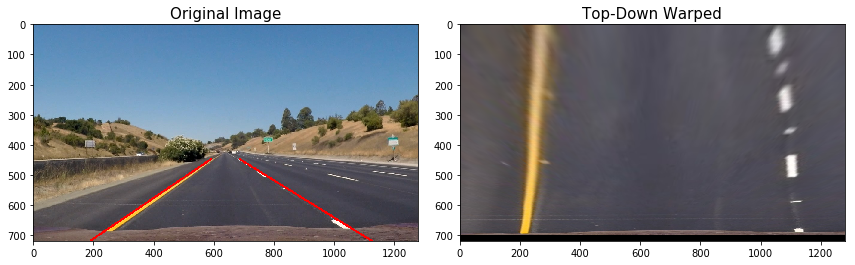

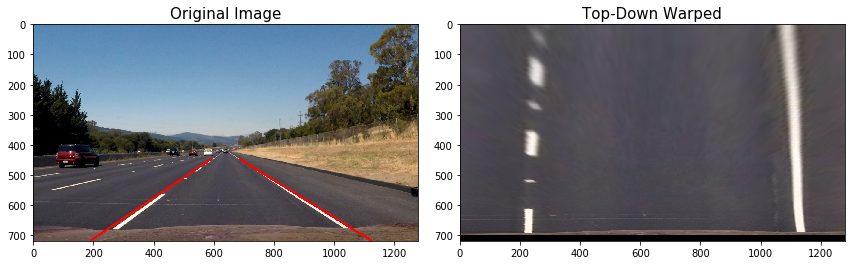

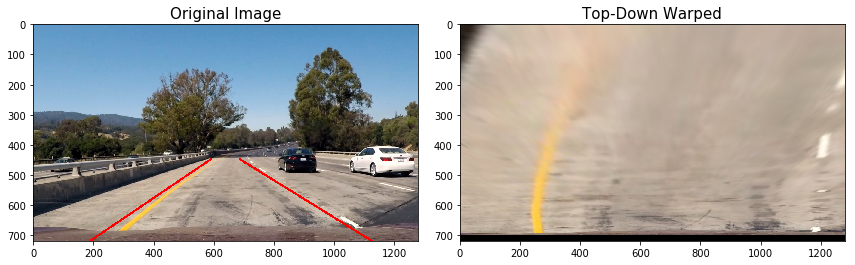

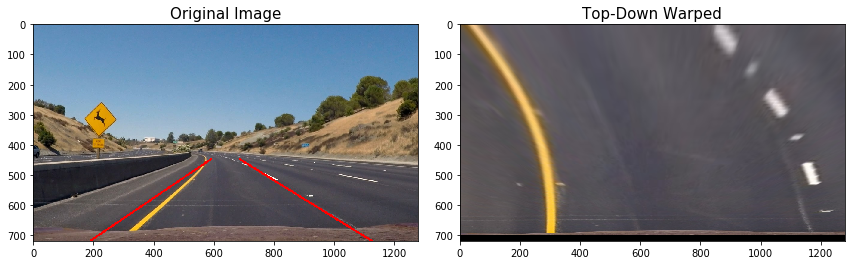

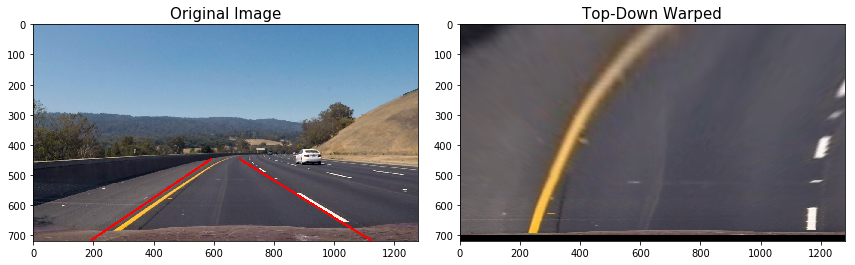

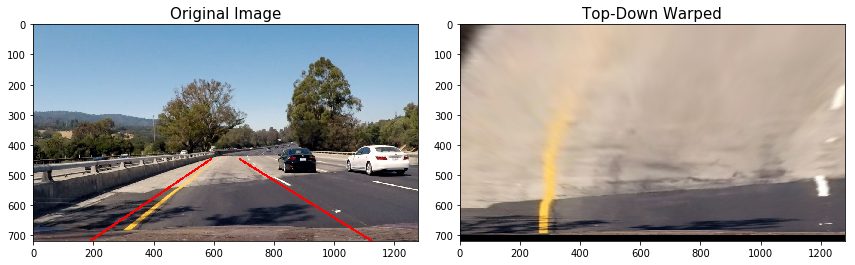

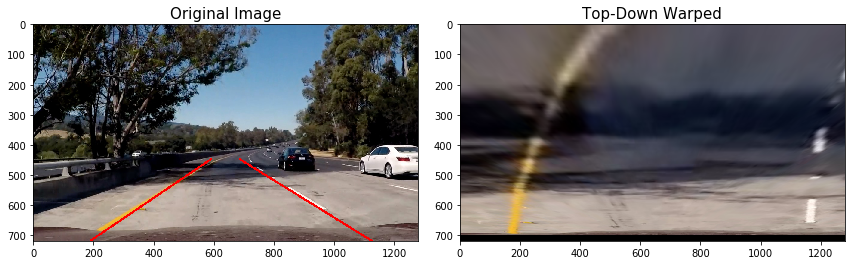

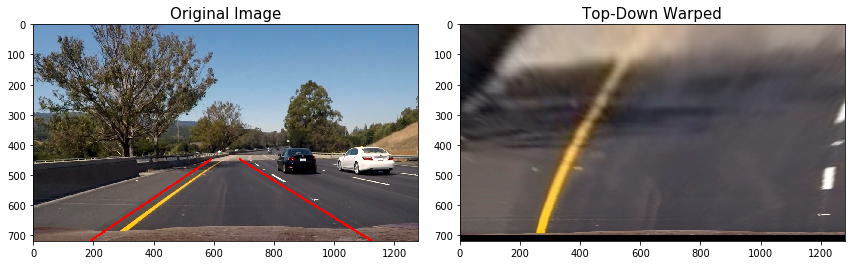

In [9]:

for fname in images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img_orig = test_img.copy()
    cv2.line(test_img_orig, (190,719), (591, 448), [255,0,0], 5)
    cv2.line(test_img_orig, (687,448), (1126, 719), [255,0,0], 5)         
    test_img, M = unwarp_lane(test_img,mtx,dist)
    
    
    plt.figure(fname)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(test_img_orig)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(test_img)
    ax2.set_title('Top-Down Warped', fontsize=15)

In [10]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    return left_curverad, right_curverad

4641.78120307 m 5839.18600659 m
17072.6628775 m 8829.28356216 m
1629.54308222 m 1682.5534094 m
1605.87593145 m 1715.63501045 m
2870.19292769 m 1961.02987346 m
1653.4426372 m 1394.83751637 m
1639.94408365 m 1524.27766393 m
2712.79699907 m 3958.55482095 m


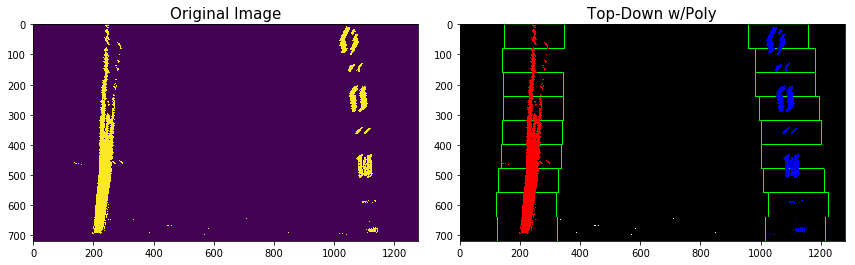

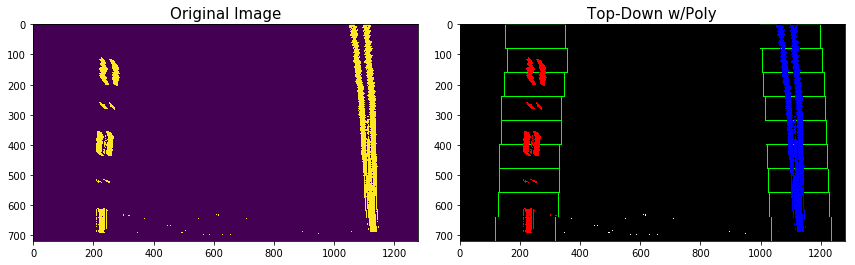

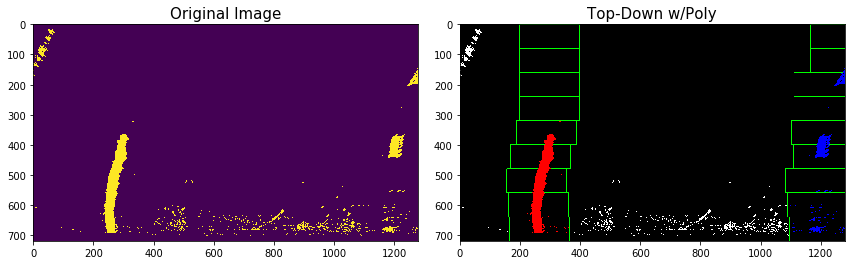

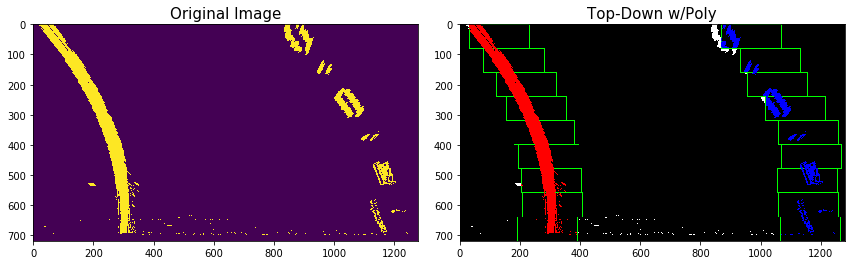

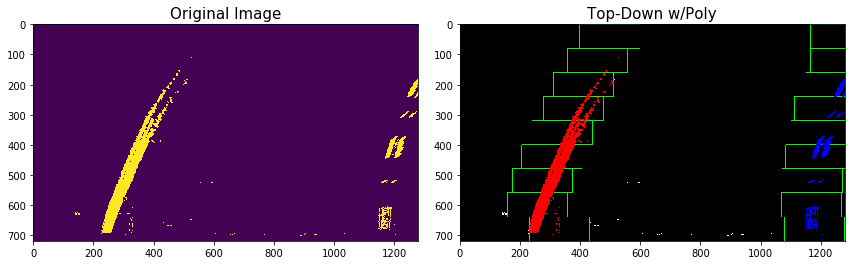

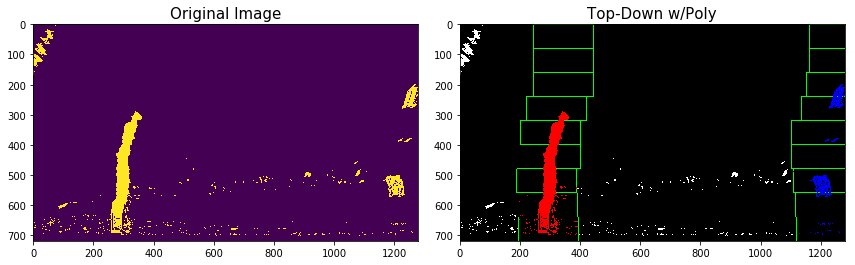

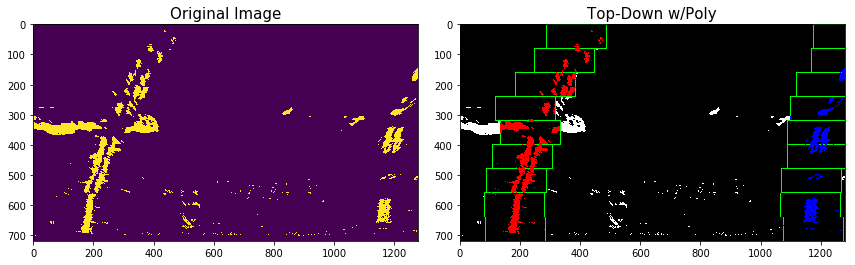

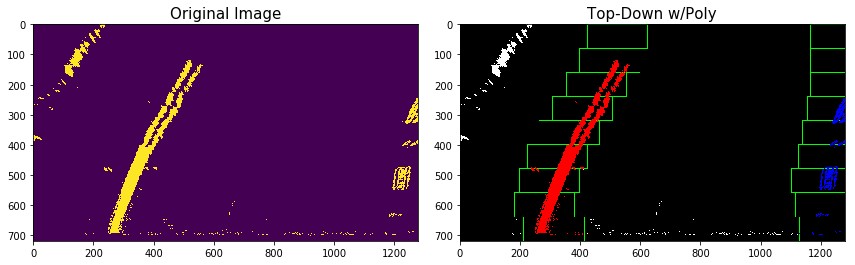

In [11]:

for fname in images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img_orig = test_img.copy()
    test_img, M = unwarp_lane(test_img,mtx,dist)
    combined, final = pipeline(test_img)
    final = cv2.cvtColor(final,cv2.COLOR_RGB2GRAY)
    
    plt.figure(fname)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(final)
    ax1.set_title('Original Image', fontsize=15)
    
    out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(final)
    
     
    ax2.imshow(out_img)
    ax2.set_title('Top-Down w/Poly', fontsize=15)
    
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)

    print(left_curverad, 'm', right_curverad, 'm')
    

In [12]:
def polyfill(top_image, img_orig, M, left_fitx, right_fitx, ploty):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_orig.shape[1], img_orig.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_orig, 1, newwarp, 0.3, 0)
    return result

## Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

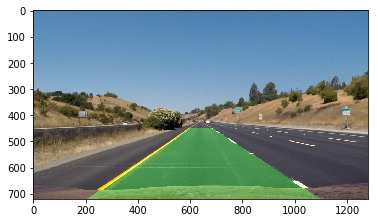

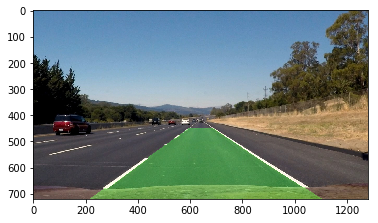

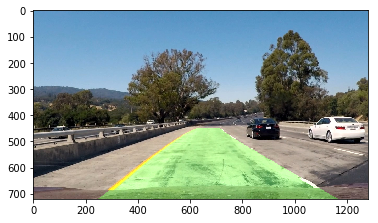

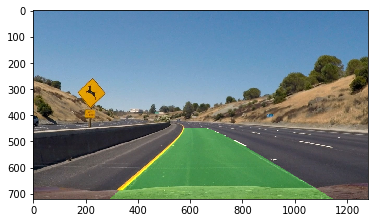

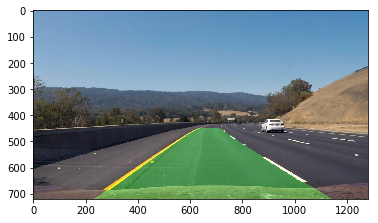

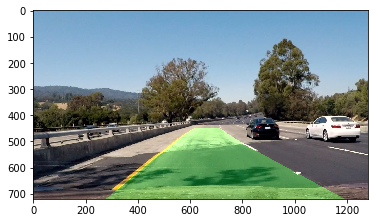

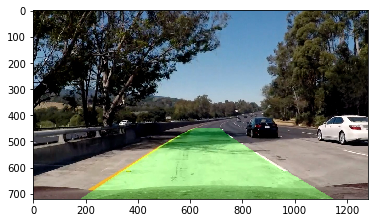

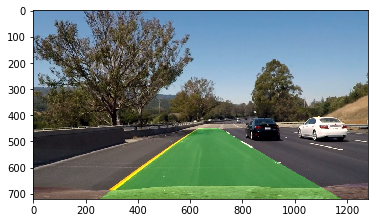

In [13]:
n = 0
for fname in images:
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img_orig = test_img.copy()
    test_img, M = unwarp_lane(test_img,mtx,dist)
    combined, final = pipeline(test_img)
    final = cv2.cvtColor(final,cv2.COLOR_RGB2GRAY)
    final_orig = final.copy()
    out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(final)
    result = polyfill(final_orig, test_img_orig, M, left_fitx, right_fitx, ploty)
    plt.figure(fname)
    plt.imshow(result)
    plt.savefig('output_images/poly'+str(n)+'.jpg')
    n = n + 1
    

# Pipeline (Video)

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        
def printToPic(result, right_fitx_act):
    # place text on image for debugging
    if left.allx.shape[1]>1:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (10,500)
        bottomLeftCornerOfText2 = (10,550)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        string = 'right fitx(act/imp):' + str(right_fitx_act[0]) + '/'+ str(right_fitx[0])+' '+ 'right last x:'+ str(right.allx[:,-2][0])
        string2 = 'best x avg:' + str(right.bestx[0])
        #print(string)
        cv2.putText(result,string, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
        
        cv2.putText(result,string2, 
        bottomLeftCornerOfText2, 
        font, 
        fontScale,
        fontColor,
        lineType)

In [15]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # declare a line instance
    global left
    global left
    global right
    global frame
        
    test_img = image
    #test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img_orig = test_img.copy()
    test_img, M = unwarp_lane(test_img,mtx,dist)
    combined, final = pipeline(test_img)
    final = cv2.cvtColor(final,cv2.COLOR_RGB2GRAY)
    final_orig = final.copy()
    out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(final)
    right_fitx_act = np.copy(right_fitx)
    left_fitx_act = np.copy(left_fitx)
    
    # initialize bestx if null
    if right.bestx == None or left.bestx == None:
        left.bestx = left_fitx
        right.bestx = right_fitx
        left.detected = True
        right.detected = True
     
    # declare a line undetected outright if the returned shape of the curve is not 720
    if left_fitx.size != 720:
        left.detected = False
    if right_fitx.size != 720:
        right.detected = False
        
    # initialize the allx arays
    if left.allx == None:
        left.allx = left_fitx.reshape(720,1)

    if right.allx == None:
        right.allx = right_fitx.reshape(720,1)

    # define offset to check for large changes from previous start
    offset = 200
    
    # check if lanes are resonable; if not, provide the bestx average for each lane
    if left_fitx_act[0] > (left.bestx[0] + offset) or left_fitx_act[0] < (left.bestx[0] - offset):    
        left_fitx = np.copy(left.bestx.reshape(720))
        left.detected = False
    else:
        left.detected = True
    if right_fitx_act[0] > (right.bestx[0] + offset) or right_fitx_act[0] < (right.bestx[0] - offset):
        right_fitx = np.copy(right.bestx.reshape(720))
        right.detected = False
    else:
        right.detected = True
        
    
    # if a lane is detected, add the fit curve to the allx struct
    # then average the last n curves in allx to store as bestx
    n = 3  # number of previous frames to average best x 
  
    if left.detected == True:
        left.allx = np.append(left.allx,left_fitx.reshape(720,1), axis=1)
    if left.allx.shape[1] < n:
        left.bestx = np.mean(left.allx, axis = 1)
    else:
        left.bestx = np.mean(left.allx[:,-n:], axis = 1)

    if right.detected == True:
        right.allx = np.append(right.allx,right_fitx.reshape(720,1), axis=1)
    if right.allx.shape[1] < n:
        right.bestx = np.mean(right.allx, axis = 1)
    else:
        right.bestx = np.mean(right.allx[:,-n:], axis = 1)

    #polynomial coefficients for the most recent fit
    left.current_fit = left_fit_cr
    right.current_fit = right_fit_cr  
    
    #radius of curvature of the line in some units
    K_left, K_right = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
    left.radius_of_curvature = K_left
    right.radius_of_curvature = K_right
        
    result = polyfill(final_orig, test_img_orig, M, left_fitx, right_fitx, ploty)
    
    # for debugging
    frame = frame + 1
    
    return result

In [17]:
def process_image_test(image):
    test_img = image
    test_img_orig = test_img.copy()
    offset = 0 #60
    offset2 = 0 #10
    cv2.line(test_img_orig, (190+offset,719), (591+offset, 448), [255,0,0], 5)
    cv2.line(test_img_orig, (687+offset2,448), (1126+offset2, 719), [255,0,0], 5)         
    test_img, M = unwarp_lane2(test_img,mtx,dist)
    combined, final = pipeline(test_img)
    final = cv2.cvtColor(final,cv2.COLOR_RGB2GRAY)
    final_orig = final.copy()
    out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(final)
    result = polyfill(final_orig, test_img_orig, M, left_fitx, right_fitx, ploty)
    
    plt.figure(fname)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 10))
    f.tight_layout()
    ax1.imshow(test_img_orig)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(test_img)
    ax2.set_title('Top-Down Warped', fontsize=15)
    ax3.imshow(out_img)
    ax3.set_title('Top-Down w/poly', fontsize=15)
    ax4.imshow(result)
    ax4.set_title('Result', fontsize=15)
    return test_img_orig

In [20]:
global left
global right
global frame

frame = 1 # for debugging

# initialize line structs
left = Line()
right = Line()

output = 'test_video_output/challenge_vid_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(40,50)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output/challenge_vid_test.mp4
[MoviePy] Writing video test_video_output/challenge_vid_test.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:20<00:00,  6.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_vid_test.mp4 

Wall time: 1min 21s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))